In [1]:
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("./Titanic/train.csv")

In [5]:
data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
columns_to_drop=['PassengerId','Name','Ticket','Cabin','Embarked']

In [8]:
data_clean=data.drop(columns_to_drop,axis=1)

In [9]:
data_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [10]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
data_clean['Sex']=le.fit_transform(data_clean['Sex'])

In [12]:
data_clean.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


In [16]:
data_clean=data_clean.fillna(data_clean['Age'].mean())

In [21]:
data_clean.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [22]:
input_cols=[ 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
output_cols=['Survived']

In [23]:
X=data_clean[input_cols]
Y=data_clean[output_cols]

In [24]:
print(X.shape,Y.shape)

(891, 6) (891, 1)


### Define entropy and information gain

In [60]:
def entropy(col):
    counts = np.unique(col,return_counts=True)
    N=float(col.shape[0])
    ent = 0.0
    for ix in counts[1]:
        p=ix/N
        ent += (-1.0*p*np.log2(p))
        
    return ent
    
    

In [61]:
col=np.array([1,1,1,1,0,1,0])
entropy(col)

0.863120568566631

In [62]:
def divide_data(x_data,fkey,fval):
    #work with pandas df
    x_right = pd.DataFrame([],columns=x_data.columns)
    x_left = pd.DataFrame([],columns=x_data.columns)    
    
    for ix in range(x_data.shape[0]):
        val = x_data[fkey].loc[ix]
        if val > fval:
            x_right=x_right.append(x_data.loc[ix])
        else:
            x_left=x_left.append(x_data.loc[ix])
    return x_left,x_right

In [65]:
def information_gain(x_data,fkey,fval):
    
    left,right = divide_data(x_data,fkey,fval)
    
    #% of samples are on left and right
    l = float(left.shape[0])/x_data.shape[0]
    r = float(right.shape[0])/x_data.shape[0]
    
    #All examples come to one side
    if left.shape[0] == 0 or right.shape[0] == 0:
        return -1000000
    
    i_gain = entropy(x_data.Survived) - (l*entropy(left.Survived) + r*entropy(right.Survived))
    
    return i_gain
    

In [66]:
## Test
for fx in X.columns:
    print(fx)
    print(information_gain(data_clean,fx,data_clean[fx].mean()))

Pclass
0.07579362743608165
Sex
0.2176601066606142
Age
0.001158644038169343
SibSp
0.009584541813400071
Parch
0.015380754493137694
Fare
0.042140692838995464


In [74]:
class DecisionTree:
    def __init__(self,depth=0,max_depth=5):
        self.left = None
        self.right = None
        self.fkey = None
        self.fval = None
        self.max_depth = max_depth
        self.depth = depth
        self.target = None
        
        
    def train(self,X_train):
        features = [ 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
        info_gains = []
        
        for ix in features:
            i_gain=information_gain(X_train,ix,X_train[ix].mean())
            info_gains.append(i_gain)
            
        self.fkey = features[np.argmax(info_gains)]
        self.fval = X_train[self.fkey].mean()
        print("Making Tree Features is ",self.fkey)
        ##split data
        data_left,data_right = divide_data(X_train,self.fkey,self.fval)
        data_left=data_left.reset_index(drop=True)
        data_right=data_right.reset_index(drop=True)
        
        
        ##reached the pure case
        if data_left.shape[0] == 0 or data_right.shape[0] == 0:
            if X_train.Survived.mean() >= 0.5:
                self.target = 'Survived'
            else:
                self.target = 'Dead'
            return
    
        ##stop early when depth > max_depth
        if self.depth >= self.max_depth:
            if X_train.Survived.mean() >= 0.5:
                self.target = 'Survived'
            else:
                self.target = 'Dead'
            return
        
        
        ##Recursive case
        self.left = DecisionTree(depth=self.depth+1,max_depth=self.max_depth)
        self.left.train(data_left)
        
        self.right = DecisionTree(depth=self.depth+1,max_depth=self.max_depth)
        self.right.train(data_right)
        
        
        ##settinh target at every node
        if X_train.Survived.mean() >= 0.5:
            self.target = 'Survived'
        else:
            self.target = 'Dead'
        return
    
    def predict(self,test):
        if test[self.fkey] > self.fval:
            ##go to right
            if self.right is None:
                return self.target
            
            return self.right.predict(test)
        
        else:
            if self.left is None:
                return self.target
            
            return self.left.predict(test)
        

### Split the data

In [76]:
split=int(0.7*data_clean.shape[0])
train_data=data_clean[:split]
test_data=data_clean[split:]
test_data=test_data.reset_index(drop=True)

In [77]:
d=DecisionTree()
d.train(data_clean)

Making Tree Features is  Sex
Making Tree Features is  Pclass
Making Tree Features is  Pclass
Making Tree Features is  Parch
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Parch
Making Tree Features is  Age
Making Tree Features is  Fare
Making Tree Features is  Parch
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Fare
Making Tree Features is  SibSp
Making Tree Features is  Fare
Making Tree Features is  Fare
Making Tree Features is  Age
Making Tree Features is  SibSp
Making Tree Features is  Parch
Making Tree Features is  Age
Making Tree Features is  SibSp
Making Tree Features is  Fare
Making Tree Features is  Parch
Making Tree Features is  Parch
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Age
Making Tree Features is  Fare
Making Tree F

In [80]:
print(d.fkey)
print(d.fval)
print(d.left.fkey)
print(d.right.fkey)

Sex
0.6475869809203143
Pclass
Fare


In [81]:
y_pred=[]
for ix in range(test_data.shape[0]):
    y_pred.append(d.predict(test_data.loc[ix]))

In [82]:
y_pred

['Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Survived',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Survived',
 'Dead',
 'Survived',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Dead',
 'Survived',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Survived',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Survived',
 'Dead',
 'Survived',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Dead',
 'Survived',
 'Survived',
 'Dead',
 'Dead',
 'Survived',
 'Dead',
 'Dea

In [83]:
y_actual=test_data[output_cols]

In [84]:
y_actual

,Survived
0,0
1,0
2,0
3,0
4,1
...,...
263,0
264,1
265,0
266,1


In [85]:
le=LabelEncoder()
y_pred=le.fit_transform(y_pred)

In [86]:
print(y_pred)

[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0
 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0
 1 0 0 0 0 1 1 1 0]


In [88]:
y_pred=np.array(y_pred).reshape(-1,1)
print(y_pred.shape,y_actual.shape)

(268, 1) (268, 1)


In [95]:
acc=np.sum(np.array(y_pred)==np.array(y_actual)) / y_pred.shape[0]

In [96]:
print(acc)

0.8619402985074627


### Decision Tree using sklearn

In [97]:
from sklearn.tree import DecisionTreeClassifier

In [100]:
sk_tree = DecisionTreeClassifier(criterion = 'entropy',max_depth=5)

In [103]:
sk_tree.predict(test_data[input_cols])

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0], dtype=int64)

In [104]:
sk_tree.score(test_data[input_cols],test_data[output_cols])

0.8283582089552238

In [106]:
DecisionTreeClassifier?

### Visualizing a Decision Tree

In [113]:
!pip install ipython

In [175]:
import pydotplus
#from sklearn.externals.six import StringIO
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz

In [176]:
!pip install graphviz

In [177]:
dot_data = StringIO()
export_graphviz(sk_tree,out_file=dot_data,filled=True,rounded=True)
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [ ]:
## Overfitting

In [130]:
X_train=train_data[input_cols]
Y_train=np.array(train_data[output_cols]).reshape((-1,))
X_test=test_data[input_cols]
Y_test=np.array(test_data[output_cols]).reshape((-1,))

In [131]:
sk_tree.score(X_train,Y_train)

0.8443017656500803

In [136]:
sk_tree=DecisionTreeClassifier(criterion='entropy',max_depth=5)

sk_tree.fit(X_train,Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [137]:
sk_tree.score(X_train,Y_train)

0.8443017656500803

In [138]:
sk_tree.score(X_test,Y_test)

0.8283582089552238

### RandomForestClassifier

In [140]:
from sklearn.ensemble import RandomForestClassifier

In [145]:
rf=RandomForestClassifier(criterion='entropy',n_estimators=10,max_depth=5)

In [146]:
rf.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10)

In [147]:
rf.score(X_train,Y_train)

0.8571428571428571

In [148]:
rf.score(X_test,Y_test)

0.8134328358208955

In [139]:
from sklearn.model_selection import cross_val_score

In [161]:
acc=cross_val_score(RandomForestClassifier(criterion='entropy',n_estimators=30,max_depth=5),X_train,Y_train,cv=5).mean()
print(acc)

0.8169806451612903


In [156]:
acc_list=[]
for i in range(1,50):
    acc=cross_val_score(RandomForestClassifier(criterion='entropy',n_estimators=i,max_depth=5),X_train,Y_train,cv=5).mean()
    acc_list.append(acc)

In [157]:
print(acc_list)

[0.6854064516129033, 0.7945419354838709, 0.7896645161290322, 0.7930064516129033, 0.8040903225806453, 0.8058064516129033, 0.7945806451612902, 0.7913290322580645, 0.8057419354838709, 0.8010064516129031, 0.8073290322580645, 0.8121161290322579, 0.8313935483870967, 0.8057806451612903, 0.8233548387096775, 0.7945290322580645, 0.8201935483870967, 0.8137032258064515, 0.8121677419354839, 0.8153548387096773, 0.8089161290322581, 0.8137419354838709, 0.8233806451612903, 0.8185806451612903, 0.8153419354838709, 0.7977290322580645, 0.8201935483870969, 0.8169548387096773, 0.8073290322580645, 0.8314322580645161, 0.8137935483870967, 0.8105161290322581, 0.8121290322580645, 0.8105548387096773, 0.8169806451612903, 0.8169548387096773, 0.8265806451612903, 0.8121935483870967, 0.824967741935484, 0.8138064516129031, 0.8186064516129032, 0.8089548387096773, 0.8217548387096774, 0.8137548387096774, 0.8169548387096774, 0.8137677419354837, 0.8233806451612903, 0.8169677419354839, 0.8153419354838709]


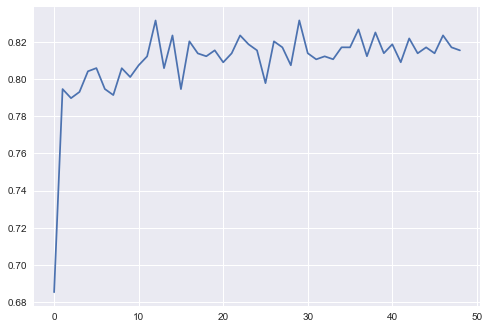

In [162]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.plot(acc_list)
plt.show()

In [160]:
print(np.argmax(acc_list))

29


In [164]:
rf=RandomForestClassifier(criterion='entropy',n_estimators=30,max_depth=5)

In [165]:
rf.fit(X_train,Y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=30)

In [166]:
rf.score(X_train,Y_train)

0.8507223113964687

In [167]:
rf.score(X_test,Y_test)

0.8395522388059702